In [1]:
import pandas as pd

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import GraphDescriptors

import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# przygotowanie danych poprzez skalowanie
# jeżeli dane mają dystrybucję normalną
def gaussianScaler(numArr):
    # standard gaussian scaler
    # X' = (X-mu)/sigma
    mean = numArr.mean()
    std = numArr.std()
    numArr = (numArr - mean) / std
    return numArr

# jeżeli dane podążają za 'power law' (~e^x)
def logScaler(numArr):
    # standard logarythmic scaler
    numArr = np.log(numArr)
    return numArr

# jeżeli dystrybucja jest niejasna
# dane dzielimy na kwantyle
def createQuantiles(dfColumn, numQuantiles):
    # create as many quantiles as wanted
    return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

# i normalizujemy minmaxem
def minMaxScaler(numArr):
    # standard minmax scaler
    minx = np.min(numArr)
    maxx = np.max(numArr)
    # linearly map all values from minimal to maximal
    # to values ranging from 0 to 1
    numArr = (numArr - minx) / (maxx - minx)
    return numArr

In [3]:
# load dataset
cp_data = pdt.LoadSDF('chembl_data_sdf/CHEMBL244_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# drop unnecessary information
print(cp_data.nunique())
# std_type jest jedyny, nie musimy go uwzględniać
# podobnie target_id target_name target_type organism i ID
# std_unit jest jedyny, nie należy go uwzględniać ani konwertować std_value
cp_data = cp_data.drop(['CdId','Mol Weight','Formula','target_id','target_name','organism','target_type','ID','std_unit','std_type'],axis=1)
cp_data.tail() # sprawdzić czy dane wyglądają OK

CdId             4226
Mol Weight       3057
Formula          3074
cmpd_chemblid    4226
std_type            1
std_value        1038
std_unit            1
target_id           1
target_name         1
organism            1
target_type         1
ID                  1
smiles           4225
dtype: int64


,cmpd_chemblid,std_value,smiles
4221,CHEMBL427842,2.6,O=C(N[C@H]1CCC[C@H]1NC(=O)c1ccc2c(Cl)c[nH]c2c1...
4222,CHEMBL1761614,305.0,CN1CCc2nc(C(=O)NC[C@@H](CC(=O)O)NC(=O)c3cc4cc(...
4223,CHEMBL272042,32.0,CCOC(=O)CN(CCCS(=O)(=O)c1ccc2cc(Cl)ccc2c1)C(=O...
4224,CHEMBL539053,40.0,CC(=N)N1CC[C@H](Oc2ccc([C@H](Cc3ccc4ccc(C(=N)N...
4225,CHEMBL371336,4.25,Nc1cc(C(=O)NC[C@H]2CN(c3ccc(N4CCOCC4=O)cc3)C(=...


<AxesSubplot:xlabel='std_value', ylabel='Density'>

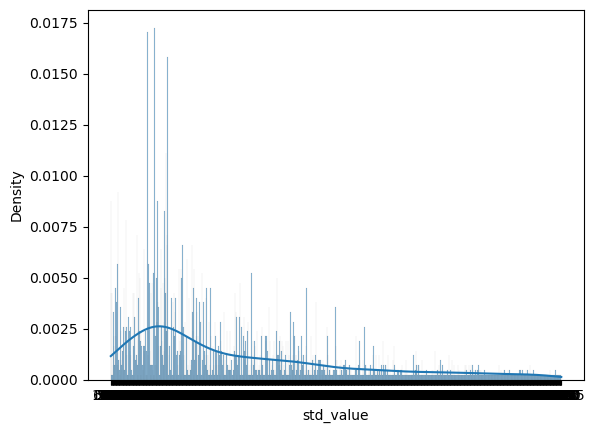

In [4]:
# sprawdzam dystrybucję danych do skalowania
# w tym wypadku jest to std_value albo aktywność związku
sns.histplot(cp_data['std_value'],kde=True,stat='density')
# dane nie mają rozróżnialnej dystrybucji, dla najlepszych efektów warto użyć kwantyli

In [5]:
class Featurizer:
    def __init__(self, smiles_col='smiles', activity_col='std_value', **kwargs):
        self.smiles_col = smiles_col
        self.activity_col = activity_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

class ClusteringFeaturizer(Featurizer):
    def __init__(self, activity_dist='gaussian', qcount=0, radius=2, length=1024, **kwargs):
        self.activity_dist = activity_dist
        self.qcount = qcount
        self.radius = radius
        self.length = length
        super().__init__(**kwargs)
    
    def __call__(self, df,quick=False):
        ## check if valid arguments
        # check activity distribution
        if(self.activity_dist != 'gaussian' and self.activity_dist != 'powerlaw' and self.activity_dist != 'quantiles'):
            print('wrongly set attribute activity_dist. Please use one of the following:\ngaussian, powerlaw, quantiles')
            return pd.DataFrame()
        # if quantiles are selected, there must be at least two of them
        if(self.activity_dist == 'quantiles' and self.qcount < 2):
            print('wrongly set quantile count.')
            return pd.DataFrame()
        # reconvert everything to float in order to prepare for scaling
        df[self.activity_col] = df[self.activity_col].astype(float)
        # generate column names for features in morgan fingerprints
        c = ['activity']+['f_'+str(n) for n in np.arange(self.length)]
        ## quick will eat more memory
        if quick:
            features = []
        else:
            features = pd.DataFrame(columns=c)
        ## prepare activity by scaling the data with scaler
        # chosen to the selected distribution
        match self.activity_dist:
            case 'gaussian':
                df[self.activity_col] = gaussianSacler(df[self.activity_col])
            case 'powerlaw':
                df[self.activity_col] = logScaler(df[self.activity_col])
            case 'quantiles':
                df[self.activity_col] = createQuantiles(df[self.activity_col], self.qcount)
                df[self.activity_col] = minMaxScaler(df[self.activity_col])
            case _:
                #do nothing
                return
        ## generate features
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            activity = row[self.activity_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            # vector containing morgan fingerprints
            fpvector = np.array(fp,dtype=int)
            # vector representing the molecule, contains
            # fingerprints and activity in floats
            vec = np.array([np.hstack(([activity],fpvector))],dtype=float)
            if quick:
                features.append(vec)
            else:
                fta = pd.DataFrame(vec,columns=c)
                features = pd.concat([features,fta],ignore_index=True)
        return features

In [6]:
feature_count = 512
quantile_count = 50
featurizer = ClusteringFeaturizer(activity_dist='quantiles',qcount=quantile_count,length=feature_count)
feature_count = (feature_count + 1) * 1.0 # + activity ; konwersja na float
data = featurizer(cp_data)
data.tail() # dane teraz wyglądają tak:

/tmp/ipykernel_234647/2240930364.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features,fta],ignore_index=True)


,activity,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511
4221,0.285714,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4222,0.877551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4223,0.612245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4224,0.632653,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4225,0.346939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='activity', ylabel='Density'>

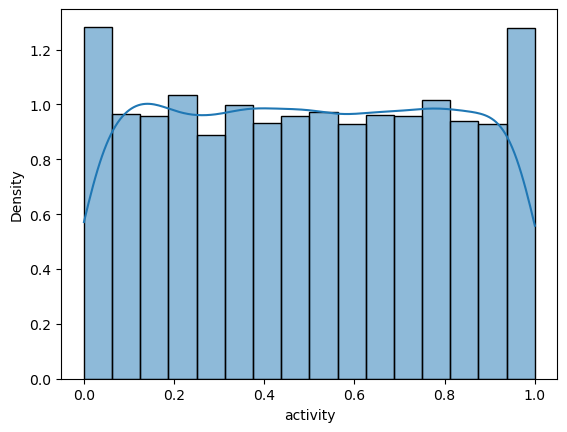

In [7]:
sns.histplot(data['activity'],kde=True,stat='density')

In [8]:
def getSimilarity(x1,x2,feature_count):
    similarity = x1 - x2
    similarity = np.sum((similarity**2.0) / feature_count)
    similarity = 1 - math.sqrt(similarity)
    return similarity

def dfSimilarity(df, centroids, feature_count):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(np.linalg.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(np.linalg.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  similarities = similarities / feature_count
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids

def pt2centroid(df, centroids, feature_cols, feature_count):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols], feature_count)
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df

def dfSimilarity(df, centroids, feature_count):
    ### dfSimilarity = Calculate similarities for dataframe input
    ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
    numPoints = len(df.index)
    numCentroids = len(centroids.index)
    ## Strictly speaking, we don't need to calculate the norm of points
    # because it adds a constant bias to distances
    # But calculating it so that the similarity doesn't go negative
    # And that we expect similarities in [0,1] which aids debugging
    pointNorms = np.square(np.linalg.norm(df, axis=1))
    pointNorms = np.reshape(pointNorms, [numPoints, 1])
    ## Calculate the norm of centroids
    centroidNorms = np.square(np.linalg.norm(centroids, axis=1))
    centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
    # Divide by the number of features
    similarities = similarities / feature_count
    # numerical artifacts lead to negligible but negative values that go to NaN on the root
    similarities = similarities.clip(min=0.0)
    # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities

def initCentroids(df, k, feature_cols):
    # Pick 'k' examples are random to serve as initial centroids
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
    # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True)
    return centroids

def pt2centroid(df, centroids, feature_cols, feature_count):
    ### Calculate similarities between all points and centroids
    ### And assign points to the closest centroid + save that distance
    numCentroids = len(centroids.index)
    numExamples = len(df.index)
    # dfSimilarity = Calculate similarities for dataframe input
    dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols], feature_count)
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)    # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)    # minimum distance
    return df

def recomputeCentroids(df, centroids, feature_cols):
    ### For every centroid, recompute it as an average of the points
    ### assigned to it
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen, feature_cols]    # all points for centroid
        if not (dfSubset.empty):    # if there are points assigned to the centroid
            clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
            centroids.loc[cen] = clusterAvg
    return centroids

def kmeans(df, k, feature_cols, feature_count, verbose):
    flagConvergence = False
    maxIter = 100
    it = 0    # ensure kmeans doesn't run for ever
    centroids = initCentroids(df, k, feature_cols)
    while not (flagConvergence):
        it += 1
        #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)
        # Perform k-means
        df = pt2centroid(df, centroids, feature_cols, feature_count)
        centroids = recomputeCentroids(df, centroids, feature_cols)
        # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print('Total distance:',np.sum(df['pt2centroid']))
        if (it > maxIter):
            print('k-means did not converge!')
            return
    print('k-means converged for ',k,' clusters after ',it,' iterations!')
    return df, centroids

In [9]:
import warnings
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [11]:
k = 30

data_process = data.copy(deep=True)

feature_cols = data_process.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
data_process['centroid'] = k
# init the point to centroid distance to an impossible value 100 (>1)
data_process['pt2centroid'] = 100
data_process, centroids = kmeans(data_process, k, feature_cols, feature_count, 1)
# now we have our clusters!
data_process.head()

Total distance: 1251.9437748350842
Total distance: 963.6510942575492
Total distance: 942.9756879190292
Total distance: 934.2313465477478
Total distance: 930.891816959518
Total distance: 928.6994388485491
Total distance: 926.4534202789289
Total distance: 924.9513429361002
Total distance: 924.0549262257538
Total distance: 923.4242667819676
Total distance: 923.1159770968775
Total distance: 922.8585998662022
Total distance: 921.9690876393012
Total distance: 921.4511586288526
Total distance: 921.4311513145093
k-means converged for  30  clusters after  15  iterations!


,activity,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,centroid,pt2centroid
0,0.204082,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,0.303116
1,0.346939,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11,0.245066
2,0.224490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,22,0.263782
3,0.591837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5,0.218135
4,0.387755,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,0.134709


In [12]:
def show_molecule(smiles=''):
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    if not mol:
        return
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    mblock = Chem.MolToMolBlock(mol, kekulize=False)

    # 3D VIEW:
    #view = py3Dmol.view(width=800, height=500)
    #view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
    #view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    #view.zoomTo({'model': -1})
    #view.show()

def examine_cluster(df,cid=0,eid=''):
    centroid = cp_data.loc[df['centroid'] == cid, :]
    mol = centroid['smiles']
    mol.reset_index()
    show_molecule(mol[int(eid)])

In [13]:
#interact(data_process,examine_cluster,cid=(0,k-1))

In [14]:
def clusterCardinality(df):
    k = np.max(df['centroid']) + 1
    k = k.astype(int)
    print('Number of clusters:' + str(k))
    clCard = np.zeros(k)
    for kk in range(k):
        clCard[kk] = np.sum(df['centroid'] == kk)
        clCard = clCard.astype(int)
    
    plt.figure()
    plt.bar(range(k), clCard)
    plt.title('Cluster Cardinality')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Points in Cluster')
    return clCard


def clusterMagnitude(df):
    k = np.max(df['centroid']) + 1
    k = k.astype(int)
    cl = np.zeros(k)
    clMag = np.zeros(k)
    for kk in range(k):
        idx = np.where(df['centroid'] == kk)
        idx = idx[0]
        clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
        
    plt.figure()
    plt.bar(range(k), clMag)
    plt.title('Cluster Magnitude')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Total Point-to-Centroid Distance')
    return clMag


def plotCardVsMag(clCard, clMag):
    plt.figure()
    plt.scatter(clCard, clMag)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Magnitude vs Cardinality')
    plt.ylabel('Magnitude')
    plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
    clCard = clusterCardinality(df)
    clMag = clusterMagnitude(df)
    plotCardVsMag(clCard, clMag)

Number of clusters:30


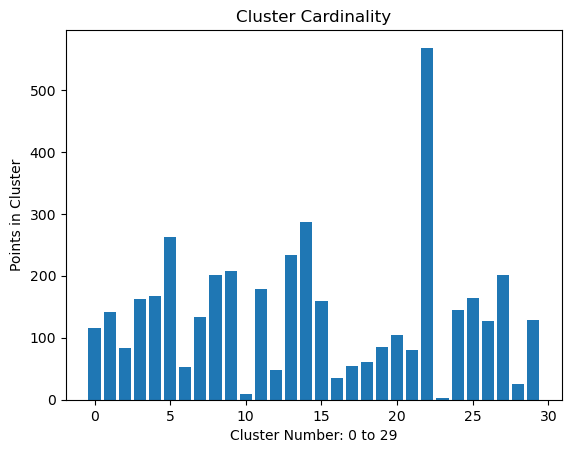

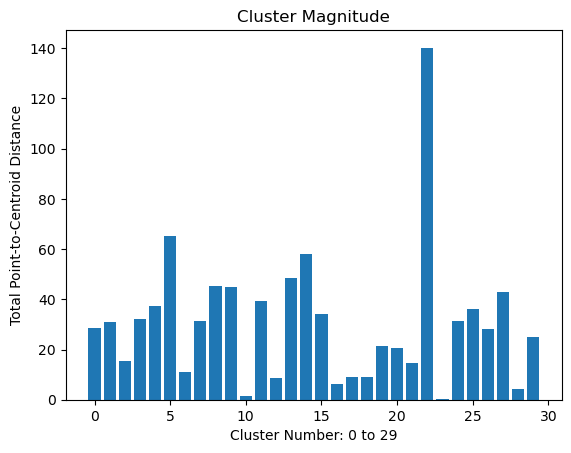

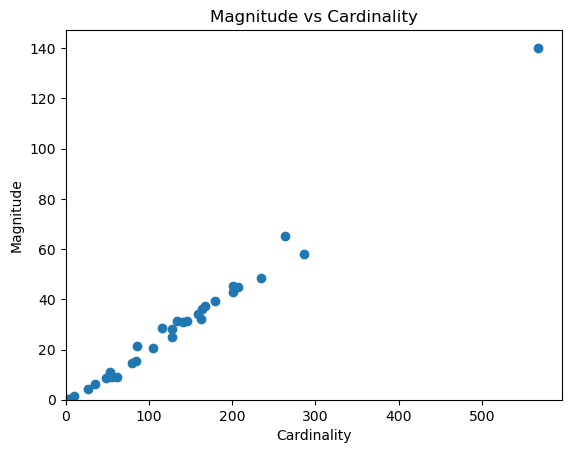

In [15]:
clusterQualityMetrics(data_process)

k-means converged for  4  clusters after  13  iterations!
k-means converged for  6  clusters after  19  iterations!
k-means converged for  8  clusters after  37  iterations!
k-means converged for  10  clusters after  11  iterations!
k-means converged for  12  clusters after  11  iterations!
k-means converged for  14  clusters after  11  iterations!
k-means converged for  16  clusters after  9  iterations!
k-means converged for  18  clusters after  10  iterations!
k-means converged for  20  clusters after  10  iterations!
k-means converged for  22  clusters after  11  iterations!
k-means converged for  24  clusters after  11  iterations!
k-means converged for  26  clusters after  11  iterations!
k-means converged for  28  clusters after  14  iterations!
k-means converged for  30  clusters after  13  iterations!
k-means converged for  32  clusters after  15  iterations!
k-means converged for  34  clusters after  14  iterations!
k-means converged for  36  clusters after  11  iterations!
k

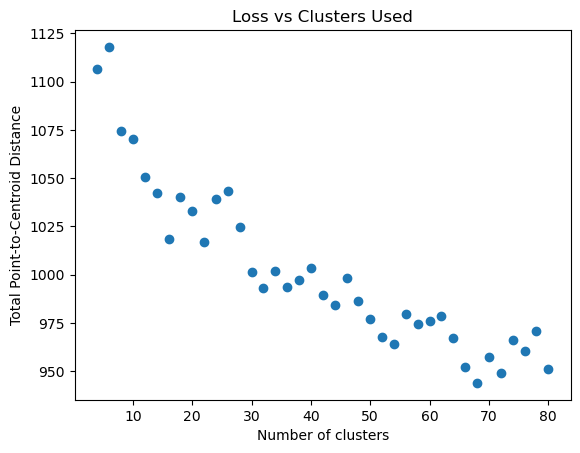

In [16]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, df):
    kmax += 1  # include kmax-th cluster in range
    kRange = range(kmin, kmax, kstep)
    loss = np.zeros(len(kRange))
    lossCtr = 0
    feature_cols = df.columns.values
    for kk in kRange:
        data_process, centroids = kmeans(df, kk, feature_cols, feature_count, 0)
        loss[lossCtr] = np.sum(data_process['pt2centroid'])
        lossCtr += 1
        
    plt.scatter(kRange, loss)
    plt.title('Loss vs Clusters Used')
    plt.xlabel('Number of clusters')
    plt.ylabel('Total Point-to-Centroid Distance')


kmin = 4 
kmax = 80
kstep = 2

data2 = data.copy(deep=True)
data2['centroid'] = k
data2['pt2centroid'] = 100

lossVsClusters(kmin, kmax, kstep, data2)